In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import rasterio
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask
import os
from shapely.geometry import Polygon

In [96]:
from IPython.display import clear_output

In [17]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [39]:
from PIL import Image

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import (
    MimeType,
    CRS,
    BBox,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    DataCollection,
    bbox_to_dimensions,
    DownloadRequest,
    MosaickingOrder,
)


In [5]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = "5674d1c3-c606-4ecf-a245-a0571a16ccff"
config.sh_client_secret = "Ry[H}7hdt3uk|)@NN]@BOjl3pI7tQA!6&I~Q}xHD"
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [119]:
gdf = gpd.read_file("F:/kuliah/Tesis/GGE tesis/Polygon/DESA_32/desa_32.shp")

In [125]:
gdf.shape

(5963, 11)

In [120]:
gdf.set_index("iddesa",inplace = True)

In [126]:
listdesa  = gdf.index.to_list()

In [138]:
listdesa = ["3212162004"]

In [139]:
len(listdesa)

1

In [133]:
betsiboka_bbox

BBox(((108.15286570950008, -6.2953327609999405), (108.52640372650006, -5.921794743999953)), crs=CRS('4326'))

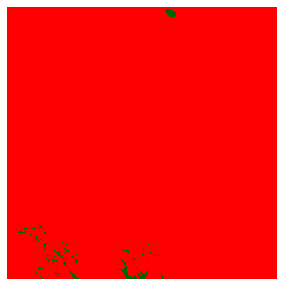

In [140]:
for name in listdesa:
    gdf_sls = gdf.filter(like = str(name),axis = 0)
    sls = gdf_sls.loc[[gdf_sls.index[0]],'geometry']
    bsls = sls.envelope
    dx = bsls.bounds.maxx -bsls.bounds.minx 
    dy = bsls.bounds.maxy -bsls.bounds.miny
    if(dy[0] > dx[0]):
        delta = dy - dx
        deltaad = delta/2
        maxy  = bsls.bounds.maxy
        miny  = bsls.bounds.miny
        maxx = bsls.bounds.maxx+deltaad
        minx = bsls.bounds.minx -deltaad
    elif(dy[0] <= dx[0]):
        delta =  dx - dy
        deltaad = delta/2
        maxy  = bsls.bounds.maxy+deltaad
        miny  = bsls.bounds.miny -deltaad
        maxx = bsls.bounds.maxx
        minx = bsls.bounds.minx
    betsiboka_coords_wgs84 = [minx, miny, maxx, maxy]
    resolution = 60
    betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
    betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)
    inter = ("2020-01-01", "2020-12-01")
    evalscript_true_color = """
        //VERSION=3

        function setup() {
            return {
                input: [{
                    bands: [ "B04", "B08"]
                }],
                output: {
                    id: "default",
                      bands: 1,
                      sampleType: SampleType.FLOAT32
                }
            };
        }

       function evaluatePixel(sample) {
          let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
          return [ ndvi ]
        }
    """

    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=("2020-01-01", "2020-12-31"),
                mosaicking_order=MosaickingOrder.LEAST_CC,
                maxcc = 0.3
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )
    true_color_imgs = request_true_color.get_data()
    ndvi = true_color_imgs[0]
    # Define color map
    nbr_colors = ["red", "darkgreen"]
    nbr_cmap = ListedColormap(nbr_colors)

    # Create classes and apply to NDVI results
    ndvi_class_bins = [-np.inf,0.25,  np.inf]
    ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

    # Apply the nodata mask to the newly classified NDVI data
    ndvi_landsat_class = np.ma.masked_where(
        np.ma.getmask(ndvi), ndvi_landsat_class
    )
    np.unique(ndvi_landsat_class)
    plt.figure(figsize=(5, 5))
    im = plt.imshow(ndvi_landsat_class, cmap=nbr_cmap)
    plt.axis('off')
    plt.savefig("C:/Users/jwst2/Python/tesis/jpg/general ndvi desa ES/"+name+".jpg", bbox_inches='tight')
    clear_output(wait = True)

In [86]:
def greenCalculator(path):
    # Load image and convert to HSV
    im = Image.open(path).convert('HSV')
    # Extract Hue channel and make Numpy array for fast processing
    Hue = np.array(im.getchannel('H'))
    # Make mask of zeroes in which we will set greens to 1
    mask = np.zeros_like(Hue, dtype=np.uint8) 
    # Set all green pixels to 1
    mask[(Hue>70) & (Hue<100)] = 1 
    # Now print percentage of green pixels
    return (mask.mean()*100)

In [87]:
greenCalculator("test.JPEG")

77.720329316074